# AUTOMATIC TICKET CLASSIFICATION - CASE STUDY
### Submitted by: RANJITH SURAM & CHETAN MURALIDHARAN

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

# Tasks to be performed:

1. Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [1]:
# Importing the necessary libraries

# Libraries for data loading and manipulation

import pandas as pd
import numpy as np
import json
import pickle


# Libraries for data visualization and EDA

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


# Libraries for text preprocessing

import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
# from subprocess import check_output
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# Libraries for machine learning models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier


# Libraries for evaluating models

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
# Suppress Warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
## Set limits for displaying rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Loading and Understanding
*  The data is in JSON format, so first we convert it to a dataframe.



In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
ls "/content/drive/MyDrive/Semantic Case Study/"

'Case Study Automatic Ticket Classification.ipynb'   complaints.json


In [6]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Semantic Case Study/complaints.json',)
  
# Returns JSON object as a dictionary 
data = json.load(f)

# Create a dataframe out of dictionary 
df = pd.json_normalize(data)

In [7]:
# Inspect the dataframe to understand the given data
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
# Shape of dataframe

df.shape

(78313, 22)

The dataset has 78,313 customer complaints and 22 features.
The customer complaint is in "_source.complaint_what_happened" column

In [9]:
# going to fetch the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

### We will have to rename the column names

In [10]:
# details of all columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

### There are many columns with missing values. But only one column with numericals that is 'score'.

In [11]:
# Statistics of all column
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### So the score column has all numerical values and no alphabets

In [12]:
# Inspect the number of missing values

df.isna().sum(0)

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

### There are columns with missing values. However, these columns will not be required in model building, so we leave them untreated.

## Data Cleaning

In [13]:
## First, we rename the column headers
# Remove the leading underscores from all column names
df.columns = [re.sub('^_', '', col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [14]:
## Remove 'source' from column names beginning with 'source.'
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [15]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [16]:
## Next, we remove the complaint rows that are blank
# Counting number of rows with blank under complaints column 

len(df[df['complaint_what_happened'] == ""])

57241

57,241 rows are blanks under complaints column.

* To remove the rows containing blanks, we first replace them by NaNs and then remove missing values. 57,241 rows in the data have blanks under complaints column.

In [17]:
# Assigning nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

# Again counting number of rows with blank under complaints column 
len(df[df['complaint_what_happened'] == ""])

0

In [18]:
df.shape

(21072, 22)

We have removed 78,313 - 21,072 = 57,241 rows that contained blank under complaints column

## Data Preprocessing

Now, we prepare the text for topic modeling
Here, we do the following preprocessing on the text of complaints:
1. Make the text lowercase
2. Remove text in square brackets
3. Remove punctuation
4. Remove words containing numbers

In [19]:
df['complaint_what_happened'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [22]:
### Confirming there is no null values in complaints column
len(df[df['complaint_what_happened'] == ""])

0

In [23]:
# Function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    '''This function 
        - makes the given text lowercase
        - removes text in square brackets
        - removes punctuation and 
        - removes words containing numbers.
    :param text: text to be cleaned
    :return: cleaned text
    '''
    
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [24]:
# Apply the above function to complaint column and make a new dataframe containing text-cleaned complaints
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_text(x)))

# View first five rows of text-cleaned dataframe
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


* Lemmatize the texts
* Use POS tags to get relevant words from the texts.

In [25]:
#Write your function to Lemmatize the texts
def lemmatizer(text):     
    """
    This function lemmatizes the given input text.
    :param text: given text
    :return: lemmatized text
    """
    
    # Initialize empty list to store lemmas
    sent = []
    
    # Extract lemmas of given text and add to the list 'sent'
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(sent)

In [26]:
# Add a column for lemmatized complaints to the dataframe
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact xxxx and be refer to chase bank i then immediately contact chase bank within no more than of get the notification on the screen and i be tell by the chase represent

* Now, we will use Chunking to extract singular nouns from the lemmatized complaints
* We extract only nouns because we are interested in finding topics, which are mostly nouns.

In [27]:
!pip install -U textblob

     |████████████████████████████████| 636 kB 5.2 MB/s 
  Attempting uninstall: textblob
    Found existing installation: textblob 0.15.3
    Uninstalling textblob-0.15.3:
      Successfully uninstalled textblob-0.15.3


In [28]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [29]:
# Extract singular nouns
def get_singular_nouns(text):
    """
    This function extracts the singular nouns from given text
    :param: input text
    :return: extracted nouns from the input text
    """
    
    # Create a textblob object
    blob = TextBlob(text)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

# Apply the function to create a new column containing only singular nouns 
# We don't have plural nouns as the text is already lemmatized
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_singular_nouns(x['lemmatized_complaint']), axis=1)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come acro

## EDA - Data Visualization
Here, we do the following steps of Exploratory Data Analysis (EDA) to get familiar with the data.
* Visualise the data according to the 'Complaint' character length
* Using a word cloud find the top 40 words by frequency among all the articles after processing the text
* Find the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text.

In [30]:
# Create list of lengths of pre-processed complaints

doc_lens = [len(d) for d in df_clean['complaint_POS_removed']]
doc_lens[:5]

[192, 102, 74, 446, 192]

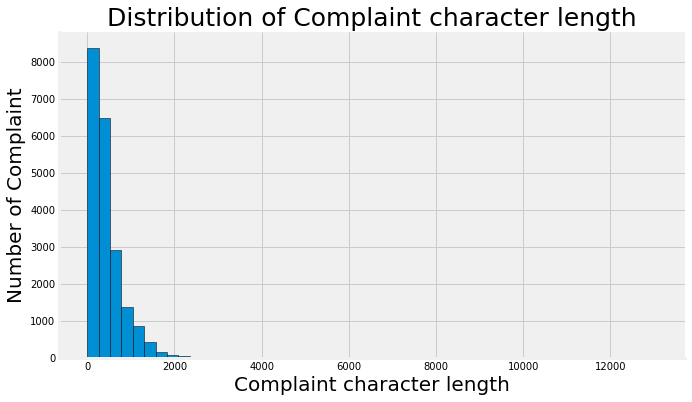

In [31]:
# Plot the data according to character length of complaints
plt.figure(figsize=(10,6))
plt.hist(doc_lens, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=25)
plt.ylabel('Number of Complaint', fontsize=20)
plt.xlabel('Complaint character length', fontsize=20)
sns.despine()
plt.show()

From the above graph we can see
* The distribution of word counts is skewed a little positive but overall it is a pretty mormal distribution.

Now, we plot the top 40 words by frequency using a word cloud

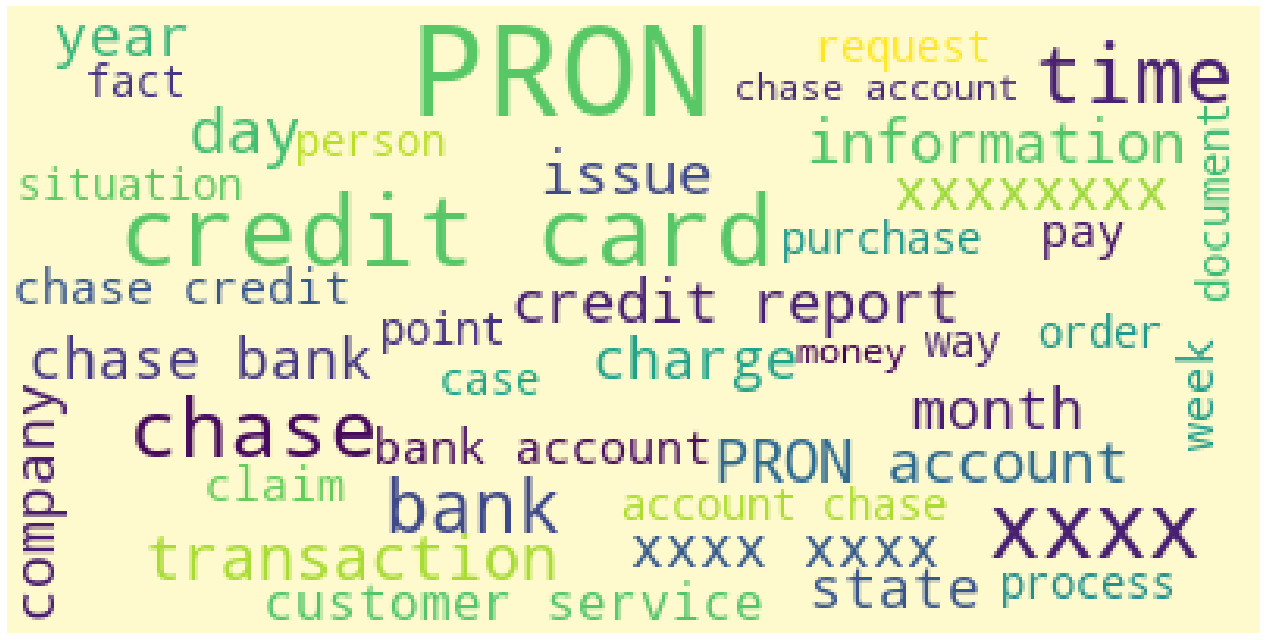

In [32]:
#Using a word cloud, we plot the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [33]:
#Removing -PRON- from the text corpus

df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

Finding the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text.

In [34]:
# We now find the top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean). 
def get_top_n_words(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n words(unigrams) among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top words(unigrams) to find
    :return: list of tuples with two elements each: the word and its frequency
    """
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

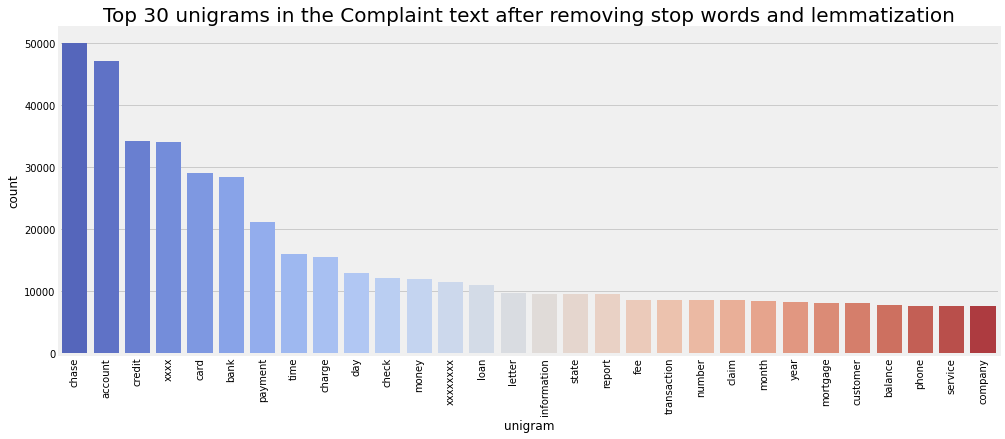

In [35]:
# Top 30 unigrams by frequency among all the complaints

common_words = get_top_n_words(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# Plot the top 30 unigrams

plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df2, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [36]:
df2.head(10)

,unigram,count
0,chase,50015
1,account,47168
2,credit,34149
3,xxxx,34013
4,card,29071
5,bank,28392
6,payment,21159
7,time,16025
8,charge,15539
9,day,12970


In [37]:
# We now find the top 30 bigram frequency among the complaints in the cleaned dataframe(df_clean). 

def get_top_n_bigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n bigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top bigrams to find
    :return: list of tuples with two elements each: the bigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

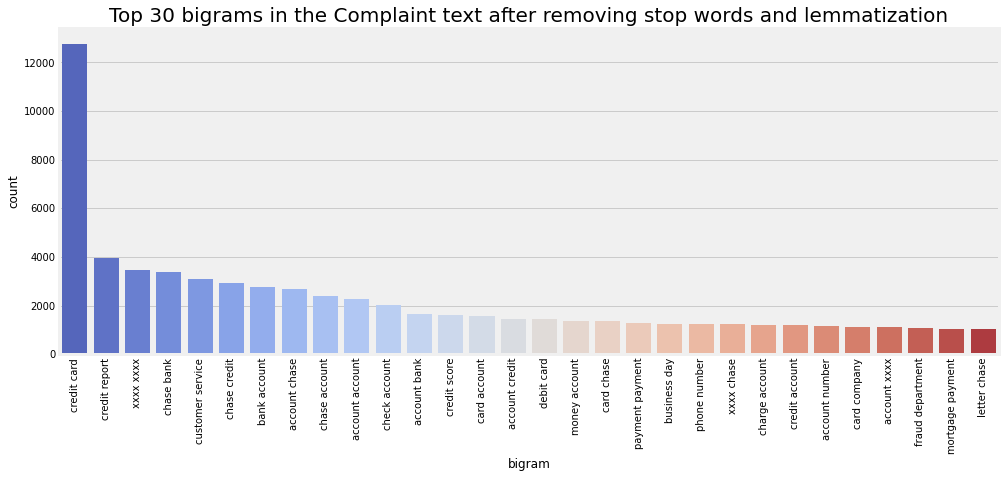

In [38]:
# Top 30 bigrams by frequency among all the complaints
common_words = get_top_n_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [39]:
#bigram frequency

df3.head(10)

,bigram,count
0,credit card,12773
1,credit report,3979
2,xxxx xxxx,3451
3,chase bank,3379
4,customer service,3078
5,chase credit,2946
6,bank account,2774
7,account chase,2698
8,chase account,2386
9,account account,2288


In [40]:
# We now find the top 30 trigram frequency among the complaints in the cleaned dataframe(df_clean). 

def get_top_n_trigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n trigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top trigrams to find
    :return: list of tuples with two elements each: the trigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

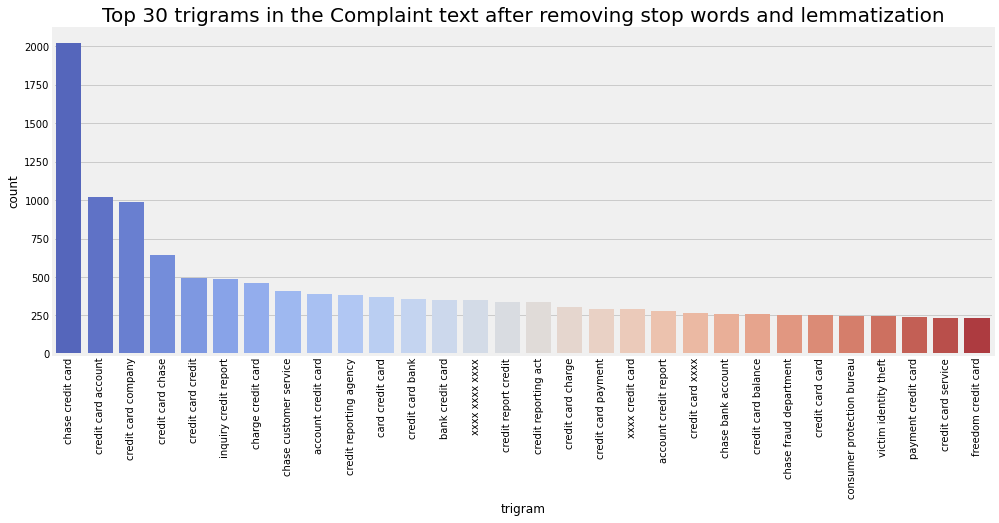

In [41]:
# Top 30 trigrams by frequency among all the complaints
common_words = get_top_n_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df4, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [42]:
# trigram frequency
df4.head(10)

,trigram,count
0,chase credit card,2021
1,credit card account,1022
2,credit card company,990
3,credit card chase,644
4,credit card credit,493
5,inquiry credit report,489
6,charge credit card,458
7,chase customer service,407
8,account credit card,386
9,credit reporting agency,381


The personal details of customer has been masked in the dataset with xxxx. We will remove the masked text as this will be of no use for our analysis.

In [43]:
# Remove masks 'xxxx' from complaints

df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [44]:
# View final pre-processed data

df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply to

## Feature Extraction

Now, we convert the raw texts to a matrix of TF-IDF features
Note: Here, we use following parameters of TfidfVectorizer:-

* max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

* min_df is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [45]:
# Initialize the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

Next, we create a document term matrix using fit_transform
1. The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
2. The tuples that are not there have a tf-idf score of 0

In [46]:
# Create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

# Topic Modelling

We now perform Topic Modelling using Non-Negative Matrix Factorization (NMF)

Definition : Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

1. We will perform the following steps:
  * Find the best number of clusters/topics
  * Apply the best number to create word clusters/topics
  * Inspect & validate the correction of each cluster for each complaint
  * Correct the labels if needed
  * Map the clusters to topics/cluster names

2. To select best number of Topics, we will use Coherence Model
With the Coherence Model we will see how to automatically select the best number of topics.

In [49]:
!pip install -U gensim

     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [50]:
# Use Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


Manual Topic Modeling
* With the Coherence Model we got the best number of topics = 5.

* The hard work is already done at this point so all we need to do is run the model.

* The only parameter that is required is the number of components i.e. the number of topics we want.

* This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [51]:
# Load nmf_model with the n_components set to 5
nmf_model = NMF(n_components=5, random_state=40)

In [52]:
# Fit the model on document term matrix
nmf_model.fit(dtm)

# View the number of features
len(tfidf.get_feature_names())

7401

In [53]:
# Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

number
day
branch
deposit
fund
chase
money
check
bank
account


In [54]:
# Print the Top 15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['car', 'year', 'chase', 'account', 'credit', 'date', 'auto', 'time', 'pay', 'day', 'fee', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'statement', 'time', 'refund', 'service', 'fraud', 'claim', 'purchase', 'merchant', 'dispute', 'transaction', 'chase', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [55]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2])

In [56]:
# Create a new 'Topic' column and assign the best topic to each of the complaints

df_clean['Topic'] = topic_results.argmax(axis=1)

# View the feature matrix
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to

In [57]:
# Print the first 5 Complaint for each of the Topics
df_clean5 = df_clean.groupby('Topic').head(5)

df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen check number xxxx claim number be xxxx with chase,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict -PRON- account by -PRON- debit card tuesday on thursday i go into a branch after be advise by a customer service representative that -PRON- account would actually be close i go into the branch to see how i can remove the fund that be in there currently in as well as if -PRON- direct deposit from -PRON- place of employment would be return the bank associate and the customer service representative assure -PRON- that the fund would post but -PRON- may take an additional business day that saturday i atte

After looking carefully at the first 5 complaints for each topics, we can assign names to topics as below

1. Topic 0: Bank Account services
2. Topic 1: Credit card or prepaid card
3. Topic 2: Others
4. Topic 3: Theft/Dispute Reporting
5. Topic 4: Mortgage/Loan

We create a dictionary and map the above names to the 5 topics

In [58]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [59]:
# View the feature matrix
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on wh

# Model Building

* Now that we have a label column, we can build Supervised model to predict any new complaints and assign them the relevant Topic.

* Since we will be using supervised learning technique, we have to convert the topic names to numbers (numpy arrays only understand numbers)

In [60]:
# Create the dictionary again of Topic names and Topic numbers
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

# Replace Topic Names with Topic numbers
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

# View the dataframe
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to

Now that we have assigned a topic to each complaint, we can select these two columns as our training data

In [61]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened","Topic"]]

# View the training data
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,4
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [62]:
# View dimensions of training data
training_data.shape

(21072, 2)

View the distribution of target variable Topic

In [63]:
# View value counts of the five topics

training_data['Topic'].value_counts()

0    5164
1    5006
3    4819
4    3852
2    2231
Name: Topic, dtype: int64

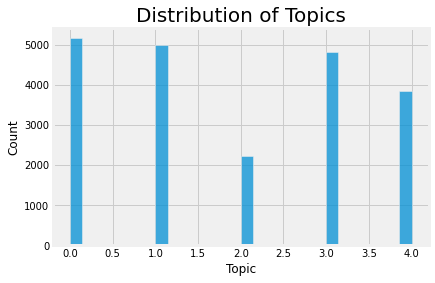

In [64]:
# Plot a histogram of classes (i.e. topics)

sns.histplot(data=training_data, x='Topic')
plt.title("Distribution of Topics", fontsize=20)
plt.show()

Selection of Evaluation Metric
* As the distribution of target variable is not normal and there is imbalance of classes, we select F1 Score as our evaluation metric for comparing the performance of various models we will build.
* Moreover, we will use a weighted average method for evaluating F1 Score due to the imbalance of classes

We can now apply the supervised models on the training data created.
In this process, we will do the following:
* Create the vector counts using Count Vectorizer
* Transform the word vector to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics

In [65]:
# Get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])


In [66]:
# Save Word Vector
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [67]:
# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [68]:
# Save TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [69]:
# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 33599)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33599)
Shape of y_test: (5268,)


Now, we will try the following models one by one and evaluate them to select the best performing one
* Naive Bayes (this will serve as a baseline model)
* Logistic regression
* Decision Tree
* Random Forest
* Support Vector Machine
* XGBoost
* CatBoost

Create a function to evaluate the classifiers

In [70]:
# Create a function to evaluate models
def eval_model(y_test, y_pred, model_name):
    """
    This function prints the classification report of a classifier 
    and plots the confusion martrix
    :param y_test: actual labels
    :param y_pred: predicted labels
    :param model_name: the name of the model being evaluated
    :return: None
    """
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

# Model 1: Naive Bayes

In [71]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
clf_nb = MultinomialNB()
%time 
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [72]:
# Calculate F1 Score using weighted average method
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.6843175872516123

Best Estimator parameters
{'alpha': 0.1, 'fit_prior': False}

In [73]:
# Run Multinomial Naive Bayes on tuned hyperparameters
clf_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
%time 
clf_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = clf_nb_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [74]:
# Calculate F1 Score of tuned model using weighted average method
f1_nb_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb_tuned

0.785515880365828

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.84      0.81      1303
Credit card or prepaid card       0.81      0.76      0.78      1290
                     Others       0.70      0.64      0.67       548
    Theft/Dispute Reporting       0.78      0.78      0.78      1204
              Mortgage/Loan       0.83      0.85      0.84       923

                   accuracy                           0.79      5268
                  macro avg       0.78      0.77      0.78      5268
               weighted avg       0.79      0.79      0.79      5268



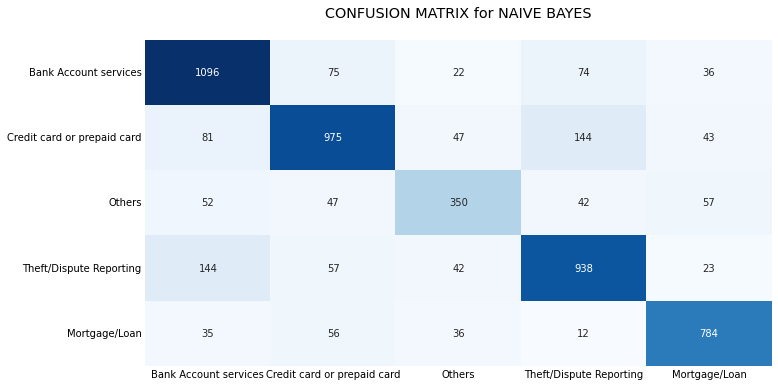

In [75]:
# Evaluate the tuned Naive Bayes classifier
eval_model(y_test, y_pred_nb_tuned, model_name)

The tuned Naive Bayes model gives a moderately well F1 score of 0.79.
* However, this model performs a bit poor on classifying Others compared to remaining four topics.
* Create a summary table to store and compare F1 Scores of all models

In [76]:
# Create a dataframe to store F1 Scores of all models we will build
summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score (untuned)': round(f1_nb, 2), 'F1 Score (tuned)': round(f1_nb_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.79


# Model 2: Logistic Regression

In [77]:
# Run the Logistic Regression model
model_name = 'LOGISTIC REGRESSION'
clf_lr = LogisticRegression(solver='liblinear')
%time 
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [78]:
# Calculate F1 Score using weighted average method
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9225620327108923

 Best Estimator parameters
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}

In [79]:
# Run Logistic Regression on tuned hyperparameters
clf_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')
%time 
clf_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = clf_lr_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [80]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr_tuned

0.9434003190687049

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.96      1303
Credit card or prepaid card       0.95      0.95      0.95      1290
                     Others       0.93      0.95      0.94       548
    Theft/Dispute Reporting       0.93      0.92      0.93      1204
              Mortgage/Loan       0.93      0.95      0.94       923

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



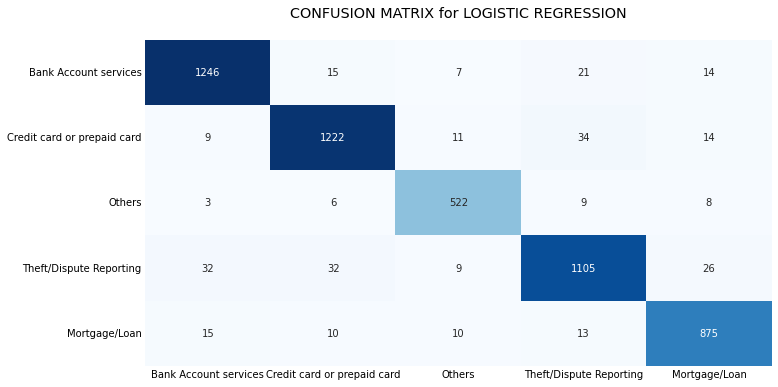

In [81]:
# Evaluate the tuned Logistic Regression classifier

eval_model(y_test, y_pred_lr_tuned, model_name)

The tuned Logistic Regression model gives a pretty high F1 score of 0.94.
This model performs well on all topics.

In [82]:
# Update the summary table
summary.loc[len(summary.index)] = ['Logistic Regression', round(f1_lr, 2), round(f1_lr_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.79
1,Logistic Regression,0.92,0.94


# Model 3: Decision Tree 

In [83]:
# Run Decision Tree on default hyperparameters
model_name = 'DECISION TREE'
clf_dt = DecisionTreeClassifier()
%time 
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [84]:
# Calculate F1 Score using weighted average method
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.7722742241835961

Best Estimator parameters:
{'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 15}

In [85]:
# Run Decision Tree on tuned hyperparameters
clf_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)
%time 
clf_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = clf_dt_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [86]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt_tuned

0.8008349176199726

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.82      0.81      1303
Credit card or prepaid card       0.83      0.83      0.83      1290
                     Others       0.80      0.76      0.78       548
    Theft/Dispute Reporting       0.76      0.74      0.75      1204
              Mortgage/Loan       0.82      0.83      0.83       923

                   accuracy                           0.80      5268
                  macro avg       0.80      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



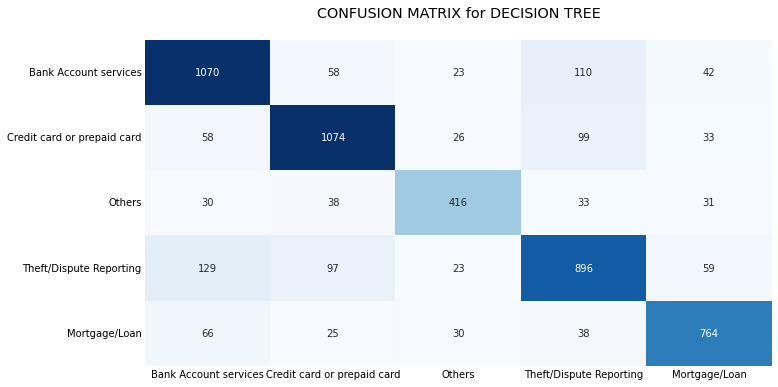

In [87]:
# Evaluate the tuned Decision Tree classifier
eval_model(y_test, y_pred_dt_tuned, model_name)

The tuned Decision Tree model gives a decent F1 score of 0.80.
* However, this model is not able to perform well on classifying Others and Theft/Dispute Reporting topics.¶

In [88]:
# Update the summary table
summary.loc[len(summary.index)] = ['Decision Tree', round(f1_dt, 2), round(f1_dt_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.79
1,Logistic Regression,0.92,0.94
2,Decision Tree,0.77,0.80


# Model 4: Random Forest 

In [89]:
# Run the Random Forest model on default hyperparameters
model_name = 'RANDOM FOREST'
clf_rf = RandomForestClassifier()
%time 
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [90]:
# Calculate F1 Score using weighted average method
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.809847107375933

Best Estimator parameters: 
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 30, 'criterion': 'gini'}

In [91]:
# Run Random Forest on tuned hyperparameters
clf_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)
%time 
clf_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = clf_rf_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [92]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
f1_rf_tuned

0.8460779793976282

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.85      0.86      0.85      1303
Credit card or prepaid card       0.87      0.87      0.87      1290
                     Others       0.83      0.82      0.83       548
    Theft/Dispute Reporting       0.82      0.80      0.81      1204
              Mortgage/Loan       0.85      0.88      0.86       923

                   accuracy                           0.85      5268
                  macro avg       0.84      0.84      0.84      5268
               weighted avg       0.85      0.85      0.85      5268



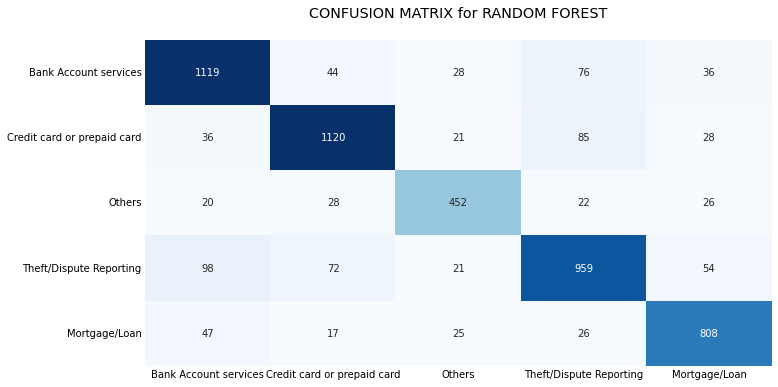

In [93]:
# Evaluate the tuned Random Forest classifier
eval_model(y_test, y_pred_rf_tuned, model_name)

The tuned Random Forest model gives a pretty high F1 score of 0.85.
This model performs quite well on all topics.

In [94]:
# Update the summary table
summary.loc[len(summary.index)] = ['Random Forest', round(f1_rf, 2), round(f1_rf_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.79
1,Logistic Regression,0.92,0.94
2,Decision Tree,0.77,0.80
3,Random Forest,0.81,0.85


# Model 5: Support Vector Machine

In [95]:
# Run the Support Vector Machine (SVM) model on default hyperparameters

model_name = 'SUPPORT VECTOR MACHINE'
clf_svm = SVC()
%time 
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [96]:
# Calculate F1 Score using weighted average method

f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
f1_svm

0.917901137350436

Best Estimator parameters: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [97]:
# Run SVM on tuned hyperparameters
clf_svm_tuned = SVC(C=10,
                    gamma='scale',
                    kernel='rbf')
%time 
clf_svm_tuned.fit(X_train, y_train)
y_pred_svm_tuned = clf_svm_tuned.predict(X_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [98]:
# Calculate F1 Score of tuned model using weighted average method
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned, average="weighted")
f1_svm_tuned

0.9211309126723004

CLASSIFICATION REPORT for SUPPORT VECTOR MACHINE

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.94      0.93      1303
Credit card or prepaid card       0.93      0.92      0.93      1290
                     Others       0.94      0.89      0.92       548
    Theft/Dispute Reporting       0.90      0.89      0.90      1204
              Mortgage/Loan       0.92      0.94      0.93       923

                   accuracy                           0.92      5268
                  macro avg       0.92      0.92      0.92      5268
               weighted avg       0.92      0.92      0.92      5268



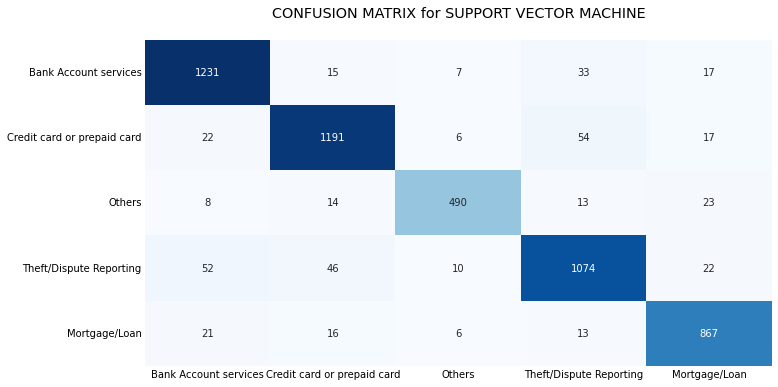

In [99]:
# Evaluate the SVM classifier
eval_model(y_test, y_pred_svm_tuned, model_name)

The SVM model gives a pretty high F1 score of 0.92.
This model performs quite well on all topics.

In [100]:
# Update the summary table
summary.loc[len(summary.index)] = ['Support Vector Machine', round(f1_svm, 2), round(f1_svm_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.79
1,Logistic Regression,0.92,0.94
2,Decision Tree,0.77,0.80
3,Random Forest,0.81,0.85
4,Support Vector Machine,0.92,0.92


# Model 6: XGBoost

In [101]:
# Run XGBoost model on default hyperparameters 
################
# This uses GPU
################

model_name = 'XGBOOST'
clf_xgb = XGBClassifier(tree_method='gpu_hist', 
                        gpu_id=0, 
                        predictor="gpu_predictor")
%time
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [102]:
# Calculate F1 Score using weighted average method
f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")
f1_xgb

0.8973117822811778

Best Estimator parameters:
{'scale_pos_weight': 12, 'n_estimators': 500, 'min_child_weight': 11, 'max_depth': 2, 'learning_rate': 0.1}

In [103]:
# Run XGBoost on tuned hyperparameters
clf_xgb_tuned = XGBClassifier(scale_pos_weight=12, 
                              n_estimators=500, 
                              min_child_weight=11, 
                              max_depth=2, 
                              learning_rate=0.1, 
                              tree_method='gpu_hist', 
                              gpu_id=0, 
                              predictor="gpu_predictor"
)
%time 
clf_xgb_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = clf_xgb_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [104]:
# Calculate F1 Score of tuned model using weighted average method
f1_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average="weighted")
f1_xgb_tuned

0.9200180107740946

CLASSIFICATION REPORT for XGBOOST

                             precision    recall  f1-score   support

      Bank Account services       0.93      0.94      0.93      1303
Credit card or prepaid card       0.93      0.92      0.92      1290
                     Others       0.90      0.93      0.91       548
    Theft/Dispute Reporting       0.91      0.89      0.90      1204
              Mortgage/Loan       0.92      0.93      0.92       923

                   accuracy                           0.92      5268
                  macro avg       0.92      0.92      0.92      5268
               weighted avg       0.92      0.92      0.92      5268



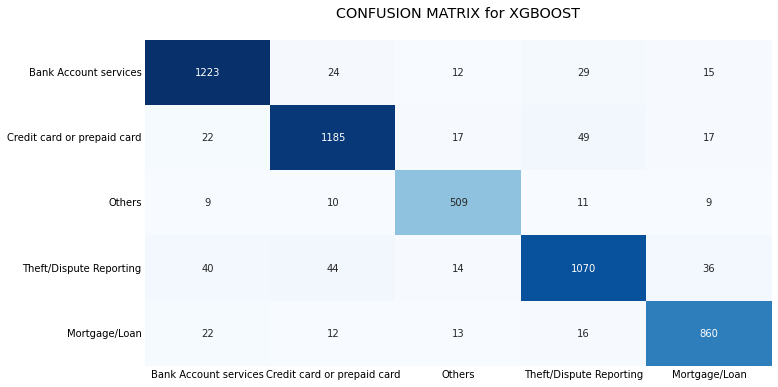

In [105]:
# Evaluate the tuned XGBoost classifier
eval_model(y_test, y_pred_xgb_tuned, model_name)

The tuned XGBoost model gives a pretty high F1 score of 0.92.
This model performs quite well on all topics.

In [106]:
# Update the summary table
summary.loc[len(summary.index)] = ['XGBoost', round(f1_xgb, 2), round(f1_xgb_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.79
1,Logistic Regression,0.92,0.94
2,Decision Tree,0.77,0.80
3,Random Forest,0.81,0.85
4,Support Vector Machine,0.92,0.92
5,XGBoost,0.90,0.92


# Model 7: CatBoost

In [107]:
# Run the CatBoost model on default hyperparameters
################
# This uses GPU
################

model_name = 'CATBOOST'
clf_cb = CatBoostClassifier(task_type="GPU",
                           loss_function='MultiClass')
%time
clf_cb.fit(X_train, y_train)
y_pred_cb = clf_cb.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Learning rate set to 0.113981
0:	learn: 1.4157845	total: 312ms	remaining: 5m 11s
1:	learn: 1.2846137	total: 460ms	remaining: 3m 49s
2:	learn: 1.1827732	total: 596ms	remaining: 3m 18s
3:	learn: 1.1088320	total: 725ms	remaining: 3m
4:	learn: 1.0448727	total: 864ms	remaining: 2m 51s
5:	learn: 0.9847291	total: 996ms	remaining: 2m 44s
6:	learn: 0.9355212	total: 1.13s	remaining: 2m 39s
7:	learn: 0.8935708	total: 1.26s	remaining: 2m 36s
8:	learn: 0.8566571	total: 1.39s	remaining: 2m 33s
9:	learn: 0.8245250	total: 1.52s	remaining: 2m 30s
10:	learn: 0.7941199	total: 1.65s	remaining: 2m 28s
11:	learn: 0.7660837	total: 1.78s	remaining: 2m 26s
12:	learn: 0.7437441	total: 1.91s	remaining: 2m 25s
13:	learn: 0.7195945	total: 2.05s	remaining: 2m 24s
14:	learn: 0.6985450	total: 2.17s	remaining: 2m 22s
15:	learn: 0.6813513	total: 2.29s	remaining: 2m 21s
16:	learn: 0.6662158	total: 2.42s	remaining: 2m 19s
17:	learn: 0.6503107	total: 2.53s	re

In [108]:
# Calculate F1 Score using weighted average method
f1_cb = f1_score(y_test, y_pred_cb, average="weighted")
f1_cb

0.9091847802816817

Best Estimator parameters:
{'l2_leaf_reg': 1e-20, 'depth': 2}

In [109]:
# Run CatBoost on tuned hyperparameters
clf_cb_tuned = CatBoostClassifier(task_type="GPU",
                                  l2_leaf_reg=1e-20,
                                  depth=2
)
%time 
clf_cb_tuned.fit(X_train, y_train)
y_pred_cb_tuned = clf_cb_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
0:	learn: 23.5017954	total: 72.1ms	remaining: 1m 12s
1:	learn: 2245382328978875351040.0000000	total: 116ms	remaining: 58.1s
2:	learn: 3786988514304167772160.0000000	total: 161ms	remaining: 53.4s
3:	learn: 10395578349458701680640.0000000	total: 196ms	remaining: 48.9s
4:	learn: 7427648499704222711808.0000000	total: 223ms	remaining: 44.3s
5:	learn: 5674379086538038312960.0000000	total: 249ms	remaining: 41.3s
6:	learn: 9061464039681627783168.0000000	total: 279ms	remaining: 39.6s
7:	learn: 11318166505433210028032.0000000	total: 306ms	remaining: 37.9s
8:	learn: 7243956676623225323520.0000000	total: 331ms	remaining: 36.5s
9:	learn: 7439926486347562352640.0000000	total: 357ms	remaining: 35.4s
10:	learn: 5141613213024750927872.0000000	total: 383ms	remaining: 34.4s
11:	learn: 5919416488477675487232.0000000	total: 406ms	remaining: 33.5s
12:	learn: 7463851577251818635264.0000000	total: 426ms	remaining: 32.4s
13:	learn: 869648603383448

In [110]:
# Calculate F1 Score of tuned model using weighted average method
f1_cb_tuned = f1_score(y_test, y_pred_cb_tuned, average="weighted")
f1_cb_tuned

0.7804902992471925

CLASSIFICATION REPORT for CATBOOST

                             precision    recall  f1-score   support

      Bank Account services       0.91      0.93      0.92      1303
Credit card or prepaid card       0.92      0.90      0.91      1290
                     Others       0.91      0.91      0.91       548
    Theft/Dispute Reporting       0.90      0.88      0.89      1204
              Mortgage/Loan       0.91      0.92      0.91       923

                   accuracy                           0.91      5268
                  macro avg       0.91      0.91      0.91      5268
               weighted avg       0.91      0.91      0.91      5268



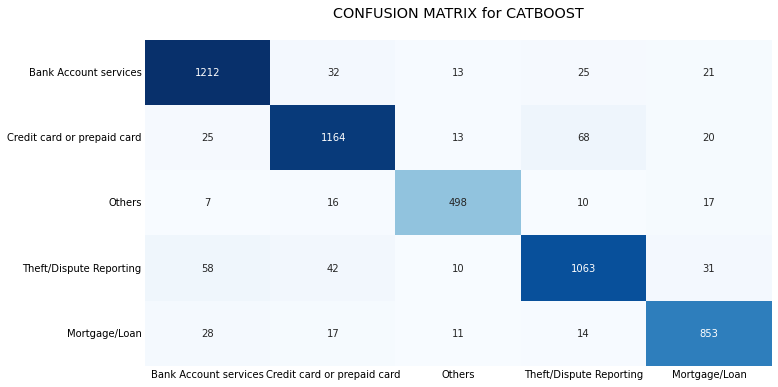

In [111]:
# Evaluate the untuned CatBoost classifier (as it performed better)
eval_model(y_test, y_pred_cb, model_name)

* The untuned CatBoost model gives a pretty high F1 score of 0.91. (Note that CatBoost is designed in a way that tuning is not necessary.)
* This model performs quite well on all topics.

In [112]:
# Update the summary table
summary.loc[len(summary.index)] = ['CatBoost', round(f1_cb, 2), round(f1_cb_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Naive Bayes,0.68,0.79
1,Logistic Regression,0.92,0.94
2,Decision Tree,0.77,0.80
3,Random Forest,0.81,0.85
4,Support Vector Machine,0.92,0.92
5,XGBoost,0.90,0.92
6,CatBoost,0.91,0.78


From the above summary table, we observe that the tuned Logistic Regression performs the best among all that we tried.

# Model Inference
Now, we use this tuned Logistic Regression model - clf_lr_tuned to predict some new custom text.

In [113]:
# Save tuned Logistic Regression model as pickle file
pickle.dump(clf_lr_tuned, open("logreg_model.pkl", "wb"))

In [114]:
# Function to predict a topic for given text

def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
    loaded_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_counts = loaded_vec.transform(text)
    X_new_tfidf = loaded_tfidf.transform(X_new_counts)
    predicted = loaded_model.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [115]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_new

,complaints
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,"Yesterday, I received a fraudulent email regarding renewal of my services."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and their locations in the city of Dubai


In [116]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))
df_new

,complaints,predicted topic
0,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit card or prepaid card
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
3,"Yesterday, I received a fraudulent email regarding renewal of my services.",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and their locations in the city of Dubai,Bank Account services


# So Here we can conclude that our regression model performs very well in classifying any new text.